In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
from jax import jit, value_and_grad, vmap
import numpy as onp
import matplotlib.pyplot as plt

In [3]:
def prop_p2p_prim(wavefront, nlamDX, nlamDY, offsetX, offsetY, sign, npupX, npupY, npixX, npixY):
    """
    Base level function that performs the MFT from one plane to another
    
    Params (non-static)
        Wavefront (complex ndarray): Input wavefront to the MFT  
        nlamDX (float): Number of fringes in X, determined by wavelength and sampling rates
        nlamDY (float): Number of fringes in Y, determined by wavelength and sampling rates
        offsetX (float): Offset of the zeroth frequency
        offestY (float): Offset of the zeroth frequency
        sign (+1 or -1): Determines if it is a pupil -> focal (+1) or focal -> pupil plane (-1)
    Params (static)
        npupX (int): Number of pixels in the X direction in the initial plane
        npupY (int): Number of pixels in the Y direction in the initial plane
        npixX (int): Number of pixels in the X direction in the final plane
        npixY (int): Number of pixels in the Y direction in the final plane
    These static parameters form a hash key for the jitted version of this fucntion
    
    Returns:
        final_wavefront
    """
    
    dU = nlamDX / float(npixX)
    dV = nlamDY / float(npixY)
    dX = 1.0 / float(npupX)
    dY = 1.0 / float(npupY)

    Xs = (np.arange(npupX, dtype=float) - float(npupX) / 2.0 - offsetX + 0.5) * dX
    Ys = (np.arange(npupY, dtype=float) - float(npupY) / 2.0 - offsetY + 0.5) * dY
    Us = (np.arange(npixX, dtype=float) - float(npixX) / 2.0 - offsetX + 0.5) * dU
    Vs = (np.arange(npixY, dtype=float) - float(npixY) / 2.0 - offsetY + 0.5) * dV
    
    XU = np.outer(Xs, Us)
    YV = np.outer(Ys, Vs)
    
    expXU = np.exp(-2.0 * np.pi * sign * 1j * XU)
    expYV = np.exp(-2.0 * np.pi * sign * 1j * YV).T

    # Note: Can casue overflow issues on 32-bit
    norm_coeff = np.sqrt((nlamDY * nlamDX) / (npupY * npupX * npixY * npixX)) 

    # Perform MFT
    t1 = np.dot(expYV, wavefront)
    t2 = np.dot(t1, expXU)
    final_wavefront = norm_coeff * t2
    
    return final_wavefront

prop_p2p_vmap = vmap(prop_p2p_prim, in_axes=(None, 0, 0, None, None, None, None, None, None, None))
prop_p2p_jit = jit(prop_p2p_vmap, static_argnums=(6,7,8,9))

---

## Construct Optical System

In [4]:
import poppy
import astropy.units as u

In [5]:
osys = poppy.OpticalSystem()
osys.add_pupil( poppy.CircularAperture(radius=3))    # pupil radius in meters
osys.add_detector(pixelscale=0.010, fov_arcsec=5.0)  # image plane coordinates in arcseconds

In [6]:
# Testing shows that the calc_psf is agnostic to wavelength, therefore we can glean all relevant information from a single dummy wavelength
# dummy_wavels = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

# Show how the wavefront has been modified
# The history property shows how everything we want is calcuatled
dummy_wavels = [1e-5]
for wavel in dummy_wavels:
    fits_out, intermediate_wfs = osys.calc_psf(wavel, return_intermediates=True)
    wf_obj = intermediate_wfs[-1]
    hist = wf_obj.history
    for j in range(len(hist)):
        print(hist[j])
    print('\n')

Created wavefront: wavelength=1e-05 m, diam=6 m
 using array size (1024, 1024)
  Multiplied WF by phasor for Pupil plane: Circle, radius=3.0 m
  Propagating wavefront to Detector plane: Detector (500x500 pixels, 0.010 arcsec / pix). 
    Propagating w/ MFT: 0.0050 arcsec / pix     fov=14.544 lam/D    npix=1000
Multiplied WF by scalar value 1.0




### These are all the relevant/populated properties we would care about
> wf_obj.wavefront

> wf_obj.wavelength

> wf_obj.shape

> wf_obj.total_intensity

> wf_obj.planetype

> wf_obj.pixelscale

> wf_obj.oversample

> wf_obj.intensity

> wf_obj.history

> wf_obj.diam

In [7]:
def get_sampling_properties(intermediate_wavefronts):
    """
    Takes in the poppy intermediate wavefront list and extracts the information we need
    Note we dont calcuate nlamD here becuase this depends on wavelength
    
    Not all the returned information is usefull but this provides a more robust
    way to get all the information 
    """
    shapes = []
    diams = []
    pixelscales = []
    fovs = []
    planetypes = []
    for wf_obj in intermediate_wavefronts:
        shape = wf_obj.shape
        diam = wf_obj.diam.to(u.m).value
        planetype = wf_obj.planetype # Conver this value into an integer later for more complex systems
        if wf_obj.planetype is poppy.poppy_core.PlaneType.pupil:
            pixelscale = wf_obj.pixelscale.to(u.m/u.pix).value
        else:
            pixelscale = wf_obj.pixelscale.to(u.radian/u.pix).value
        fov = [shape[0]*pixelscale, shape[1]*pixelscale]
        shapes.append(shape)
        diams.append(diam)
        pixelscales.append(pixelscale)
        fovs.append(fov)
        planetypes.append(planetype)
    return shapes, diams, pixelscales, fovs, planetypes

In [8]:
shapes, diams, pixelscales, fovs, planetypes = get_sampling_properties(intermediate_wfs)

shapes = np.array(shapes)
diams = np.array(diams)
pixelscales = np.array(pixelscales)
fovs = np.array(fovs)
# planetypes = np.array(planetypes)

print(shapes)
print(diams)
print(pixelscales)
print(fovs)

[[1024 1024]
 [1000 1000]]
[6. 6.]
[5.85937500e-03 2.42406841e-08]
[[6.00000000e+00 6.00000000e+00]
 [2.42406841e-05 2.42406841e-05]]


---

## Now we use this information to construct psfs of arbirary spectra

In [9]:
min_wavel = 1e-5
max_wavel = 2e-5
nwavels = 25

wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [10]:
nplanes = len(shapes)

for i in range(nplanes - 1):
    npup = shapes[i]
    npix = shapes[i+1]
    nlamD = fovs[i+1] * diams[i]
    
nlamDXs = nlamD[0]/wavels
nlamDYs = nlamD[0]/wavels
NlamDs = np.array([nlamDXs, nlamDYs])

offsets = np.array([0., 0.])
sign = +1.

In [11]:
def normalise_wf(wavefront):
    norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
    norm_wavefront = wavefront/norm_factor
    return norm_wavefront

In [12]:
initial_wf = intermediate_wfs[0].wavefront
norm_wf = normalise_wf(initial_wf)

In [13]:
# Compile in a lazy way
wfs = prop_p2p_jit(initial_wf, 
                   NlamDs[0][0:2], 
                   NlamDs[1][0:2], 
                   offsets[0], 
                   offsets[1], 
                   sign, 
                   float(npup[0]), 
                   float(npup[1]), 
                   float(npix[0]), 
                   float(npix[1]))

In [14]:
%%time
wfs = prop_p2p_jit(norm_wf, 
                   NlamDs[0], 
                   NlamDs[1], 
                   offsets[0], 
                   offsets[1], 
                   sign, 
                   float(npup[0]), 
                   float(npup[1]), 
                   float(npix[0]), 
                   float(npix[1]))

CPU times: user 20.8 s, sys: 334 ms, total: 21.2 s
Wall time: 2.47 s


In [15]:
psfs = np.abs(wfs)**2
psf_final = np.sum(psfs, axis=0)/nwavels

In [16]:
%%time
poppy_psf = osys.calc_psf(wavels)[0].data

CPU times: user 39.2 s, sys: 3.86 s, total: 43.1 s
Wall time: 5.59 s


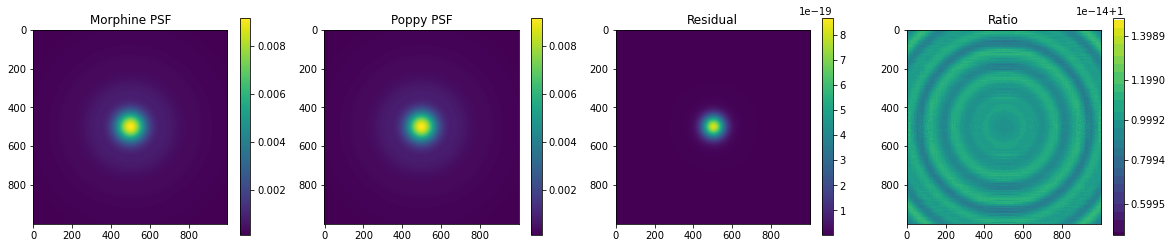

In [17]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.imshow(psf_final**0.5)
plt.title("Morphine PSF")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(poppy_psf**0.5)
plt.title("Poppy PSF")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(poppy_psf - psf_final)
plt.title("Residual")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(poppy_psf/psf_final)
plt.title("Ratio")
plt.colorbar()
plt.show()

In [18]:
result = bool(np.allclose(psf_final, poppy_psf))

if result is True:
    print("Yee Haaw!")
else:
    print("Better luck next time :'(")
    plt.imshow(np.isclose(psf_final, poppy_psf))
    plt.colorbar()
    plt.show()

Yee Haaw!
